# Zalando Bot: AI-Powered Fashion Assistant

> Retriever - Milvus Hybrid Search

In [ ]:
%pip install -qU pymilvus==2.4.6
%pip install -qU "pymilvus[model]"
%pip install -qU langchain-milvus==0.1.4

In [25]:
import base64
import os
from io import BytesIO
from base64 import b64encode

import pandas as pd
import PIL
from PIL import Image
from IPython.core.display import HTML
from IPython.display import display, HTML
import torch
from sentence_transformers import SentenceTransformer

from pymilvus import (
    AnnSearchRequest,
    Collection,
    WeightedRanker,
    connections
)

from langchain_milvus.utils.sparse import BM25SparseEmbedding

## Load Catalog

In [2]:
metadata_uri = "../data/processed_data/metadata.csv"
metadata = pd.read_csv(metadata_uri)

## Load Milvus VectorStore

In [3]:
milvus_db_uri = "../data/db/milvus_db/zalando_fashionista.db"
connections.connect(uri=milvus_db_uri)

In [4]:
# load the existing collection
collection_name = 'zalando_fashionista_collection'
collection = Collection(collection_name)
collection.load()

## Load Sparse

In [5]:
bm25_model = BM25SparseEmbedding(corpus=metadata['description'].values.tolist())

## Load Dense

> CLIP

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

# load a CLIP model from huggingface
clip_model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)

clip_model

Device:  cuda


/mnt/d/vault/devhub/zalando_query_bot/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


SentenceTransformer(
  (0): CLIPModel()
)

## Search

In [22]:
def hybrid_search(
    collection,
    query_dense_embedding,
    query_sparse_embedding,
    sparse_weight=1.0,
    dense_weight=1.0,
    limit=10,
):
    dense_search_params = {"metric_type": "IP", "params": {}}
    dense_req = AnnSearchRequest(
        [query_dense_embedding], "dense_vector", dense_search_params, limit=limit
    )
    sparse_search_params = {"metric_type": "IP", "params": {}}
    sparse_req = AnnSearchRequest(
        [query_sparse_embedding], "sparse_vector", sparse_search_params, limit=limit
    )
    rerank = WeightedRanker(sparse_weight, dense_weight)
    resp = collection.hybrid_search(
        [sparse_req, dense_req], rerank=rerank, limit=limit, output_fields=["sku"]
    )[0]
    
    return [hit.get("sku") for hit in resp]

## Ask your query

### Display results

In [23]:
def arrange_images(img_paths):
    # create an HTML string to display images side by side
    html_str = ""
    for img_path in img_paths:
        # open the image
        img = Image.open(img_path)
        
        # convert the image to a base64 string
        buffer = BytesIO()
        img.save(buffer, format="JPEG")
        img_str = buffer.getvalue()
        img_base64 = base64.b64encode(img_str).decode("utf-8")

        # add image to HTML string
        html_str += f'<img src="data:image/jpeg;base64,{img_base64}" style="display:inline-block;margin:10px;width:200px;height:auto;"/>'

    # display the HTML
    display(HTML(html_str))

def display_images(skus: list):
    imgs_urls = []    
    for sku in skus:
        img_url = metadata[metadata['sku']==sku]['img_uri'].values[0]
        imgs_urls.append(img_url)
    arrange_images(imgs_urls)

User query:  I'm looking for blue colour jeans for women


Hybrid search results:  ['MKN21N002-K16', 'E1N21N00G-K14', 'ONA21N09G-K11', 'TO221N0FD-K11', 'STH21N0BV-K11', 'BUO21N053-K12', 'VEE21N08F-K11', '1LE21N00W-K11', 'M5921N035-K11', 'M9121N1TM-K11']



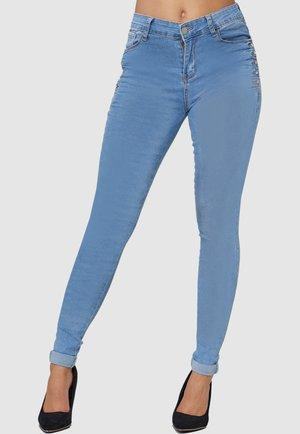
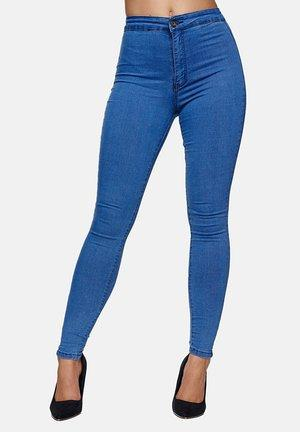
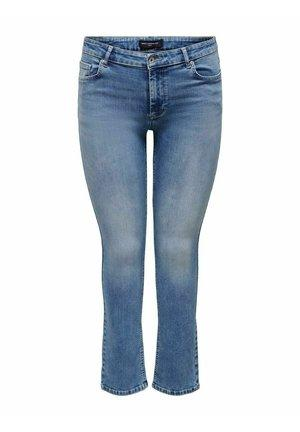
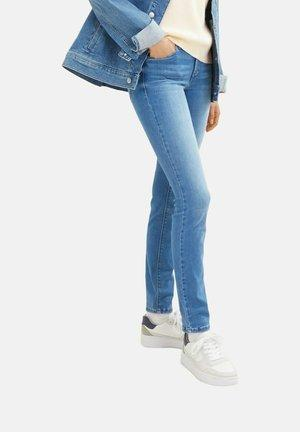
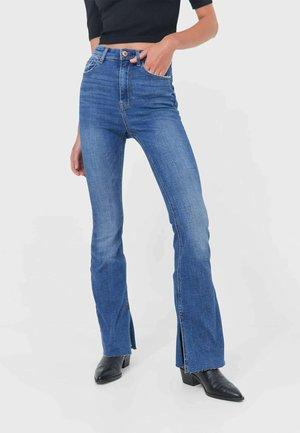
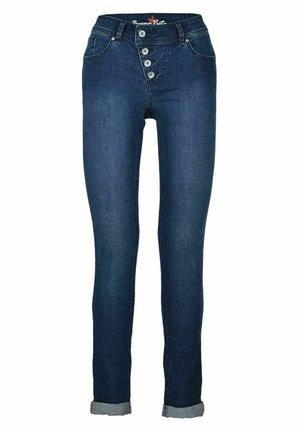
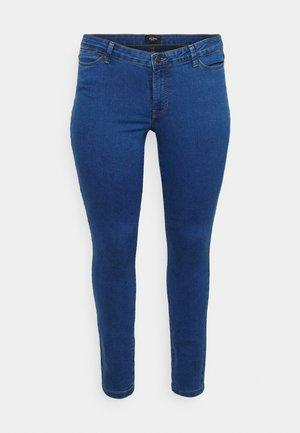
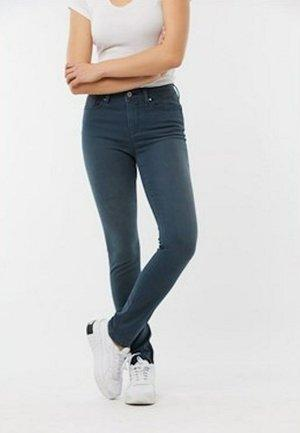
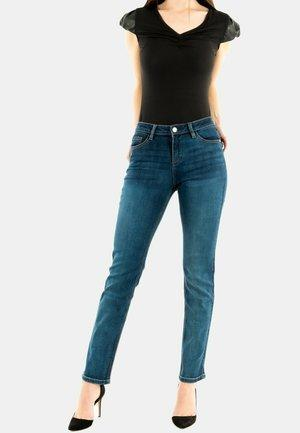
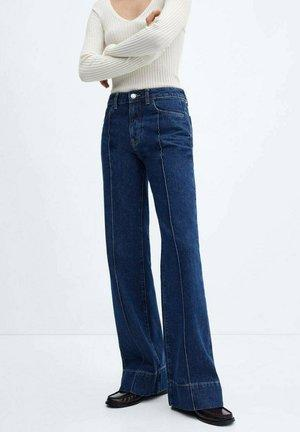

In [24]:
query = "I'm looking for blue colour jeans for women"
print("User query: ", query)
print("\n")

sparse_query_embeds = bm25_model.embed_documents([query])[0]
dense_query_embeds = clip_model.encode(query)  

hybrid_results = hybrid_search(
    collection,
    dense_query_embeds,
    sparse_query_embeds,
    sparse_weight=0.5,
    dense_weight=0.5,
)

print("Hybrid search results: ", hybrid_results)
display_images(hybrid_results)